In [ ]:
# !pip install  dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html (For CUDA 12.4, colab/kaggle environment)
!pip install dgl -f https://data.dgl.ai/wheels/repo.html
!pip install torch
!pip install rdkit
!pip install scikit-learn
!pip install pandas
!pip install torchdata==0.9.0
!pip install networkx
!pip install py3Dmol

Looking in links: https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.3/797.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2

In [ ]:
import pandas as pd
df = pd.read_csv("/content/Enoyl_bioactivities_features.csv")
df.head()

,Smiles,pChEMBL Value,Molecular Weight,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,O=C(c1ccccc1)N1CCN(C(c2ccc(F)cc2)c2ccc(F)cc2)CC1,5.69,392.45,22.753386,16.966284,0,1,38.572846,2.426953,4.853906,...,10.242279,64.502044,392.170020,7.689608,2336,46,152.0,178.0,8.250000,6.388889
1,Cc1nc2ccccc2c(=O)n1CC(=O)Nc1cc(C(C)(F)F)ccc1Cl,5.04,391.81,21.156602,16.960691,0,2,33.476026,2.445013,4.890025,...,10.320519,62.469945,391.089911,9.095114,1926,45,144.0,169.0,10.562500,5.722222
2,Cc1nc2ccc(Cl)cc2c(=O)n1CC(=O)NCc1cccs1,5.17,347.83,17.953468,14.740550,0,2,29.696659,2.453741,4.907320,...,10.024421,70.428217,347.049525,9.379717,1271,34,120.0,140.0,7.638889,5.027778
3,CCCCCCc1ccc(Oc2ccccn2)c(O)c1,4.94,271.36,14.918192,11.757315,0,0,25.941002,2.323653,4.647307,...,9.514363,52.625656,271.157229,6.613591,974,25,94.0,104.0,5.944444,4.694444
4,CCCCCCc1ccc(Oc2cccnc2)c(O)c1,6.63,271.36,14.918192,11.757315,0,0,25.941002,2.323653,4.647307,...,9.514363,52.625656,271.157229,6.613591,974,25,94.0,104.0,5.944444,4.694444


# Data Prep

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw  
import dgl
import dgl.function as fn
from dgl.nn import GraphConv, GATConv, SAGEConv  
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt  
from rdkit.Chem.Draw import IPythonConsole 

def get_atom_features(atom):
    atom_type = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'I', 'Unknown']
    atom_type_enc = [0.0] * len(atom_type)
    try:
        atom_type_enc[atom_type.index(atom.GetSymbol()) if atom.GetSymbol() in atom_type else -1] = 1.0
    except ValueError:
        atom_type_enc[-1] = 1.0

    hybridization_types = [
        Chem.rdchem.HybridizationType.SP,
        Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3,
        Chem.rdchem.HybridizationType.SP3D,
        Chem.rdchem.HybridizationType.SP3D2,
        Chem.rdchem.HybridizationType.UNSPECIFIED,
        Chem.rdchem.HybridizationType.S,
    ]
    hybridization = [0.0] * len(hybridization_types)
    try:
        hybridization_idx = hybridization_types.index(atom.GetHybridization())
        hybridization[hybridization_idx] = 1.0
    except ValueError:
        hybridization[-1] = 1.0

    atomic_num = [float(atom.GetAtomicNum())]
    degree = [float(atom.GetDegree())]
    total_num_hs = [float(atom.GetTotalNumHs())]
    formal_charge = [float(atom.GetFormalCharge())]
    is_aromatic = [float(atom.GetIsAromatic())]
    num_radical_electrons = [float(atom.GetNumRadicalElectrons())]
    in_ring = [float(atom.IsInRing())]

    features = atomic_num + degree + total_num_hs + is_aromatic + formal_charge + atom_type_enc + hybridization + num_radical_electrons + in_ring
    return torch.tensor(features, dtype=torch.float)


def get_bond_features(bond):
    bond_type = [
        Chem.rdchem.BondType.SINGLE,
        Chem.rdchem.BondType.DOUBLE,
        Chem.rdchem.BondType.TRIPLE,
        Chem.rdchem.BondType.AROMATIC,
    ]
    bond_feats = [int(bond.GetBondType() == bt) for bt in bond_type]
    bond_feats.extend([
        int(bond.GetIsConjugated()),
        int(bond.IsInRing()),
        int(bond.GetStereo() > 0),
    ])

    stereo_types = [
        Chem.rdchem.BondStereo.STEREONONE,
        Chem.rdchem.BondStereo.STEREOANY,
        Chem.rdchem.BondStereo.STEREOZ,
        Chem.rdchem.BondStereo.STEREOE,
        Chem.rdchem.BondStereo.STEREOCIS,
        Chem.rdchem.BondStereo.STEREOTRANS
    ]
    stereo_feats = [int(bond.GetStereo() == st) for st in stereo_types]
    bond_feats.extend(stereo_feats)
    return torch.tensor(bond_feats, dtype=torch.float)


def smiles_to_graph(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        # Get largest fragment
        fragments = Chem.GetMolFrags(mol, asMols=True)
        if len(fragments) > 1:
            mol = max(fragments, key=lambda m: m.GetNumAtoms())

        g = dgl.DGLGraph()
        g.add_nodes(mol.GetNumAtoms())

        node_features = [get_atom_features(atom) for atom in mol.GetAtoms()]
        g.ndata['feat'] = torch.stack(node_features)

        src_list = []
        dst_list = []
        edge_features = []
        for bond in mol.GetBonds():
            u = bond.GetBeginAtomIdx()
            v = bond.GetEndAtomIdx()
            src_list.extend([u, v])
            dst_list.extend([v, u])
            bond_feat = get_bond_features(bond).tolist()
            edge_features.extend([bond_feat, bond_feat])

        g.add_edges(src_list, dst_list)

        if edge_features:
            g.edata['feat'] = torch.tensor(edge_features, dtype=torch.float)
        else:
            num_bond_features = 10
            g.edata['feat'] = torch.zeros((0, num_bond_features), dtype=torch.float)
        return g

    except Exception as e:
        print(f"Error converting SMILES {smiles}: {str(e)}")
        return None


def prepare_dataset(csv_path, test_size=0.2, valid_size=0.1, random_state=42):
    df = pd.read_csv(csv_path)

    df.dropna(subset=['Smiles', 'pChEMBL Value'], inplace=True)
    df['pChEMBL Value'] = pd.to_numeric(df['pChEMBL Value'], errors='coerce')
    df.dropna(subset=['pChEMBL Value'], inplace=True)  
    valid_smiles = []
    for smiles in df['Smiles']:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            valid_smiles.append(smiles)
    invalid_smiles_count = len(df) - len(valid_smiles)
    print(f"Removed {invalid_smiles_count} invalid SMILES strings.")
    df = df[df['Smiles'].isin(valid_smiles)]
    cleaned_smiles = []
    for smiles in df['Smiles']:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
          fragments = Chem.GetMolFrags(mol, asMols=True)
          if len(fragments) > 1:
              largest_fragment = max(fragments, key=lambda m: m.GetNumAtoms())
              cleaned_smiles.append(Chem.MolToSmiles(largest_fragment))
          else:
              cleaned_smiles.append(smiles)
        else:
          cleaned_smiles.append(None)
    df['Smiles'] = cleaned_smiles
    df.dropna(subset=['Smiles'], inplace=True)

    df.sort_values('pChEMBL Value', ascending=False, inplace=True)
    df.drop_duplicates(subset=['Smiles'], keep='first', inplace=True)

    lower_bound = df['pChEMBL Value'].quantile(0.01)
    upper_bound = df['pChEMBL Value'].quantile(0.99)
    df['pChEMBL Value'] = np.clip(df['pChEMBL Value'], lower_bound, upper_bound)



    df['graph'] = df['Smiles'].apply(smiles_to_graph)
    df.dropna(subset=['graph'], inplace=True)


    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    train_df, valid_df = train_test_split(train_df, test_size=valid_size / (1-test_size), random_state=random_state)

    return train_df, valid_df, test_df



def collate(samples):
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels, dtype=torch.float32)



csv_path = "/content/Enoyl_bioactivities_features.csv"
train_df, valid_df, test_df = prepare_dataset(csv_path)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")



if not train_df.empty:
    print("Example Graph Features:")
    print("Node features:", train_df.iloc[0]['graph'].ndata['feat'])
    print("Edge features:", train_df.iloc[0]['graph'].edata['feat'])


from torch.utils.data import DataLoader

train_loader = DataLoader(list(zip(train_df['graph'], train_df['pChEMBL Value'])), batch_size=32, shuffle=True, collate_fn=collate)
valid_loader = DataLoader(list(zip(valid_df['graph'], valid_df['pChEMBL Value'])), batch_size=32, shuffle=False, collate_fn=collate)
test_loader = DataLoader(list(zip(test_df['graph'], test_df['pChEMBL Value'])), batch_size=32, shuffle=False, collate_fn=collate)




for batched_graph, labels in train_loader:
   print("Batched graph:", batched_graph)
   print("Labels:", labels)
   break

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
Removed 0 invalid SMILES strings.


/usr/local/lib/python3.11/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


Train set size: 233
Validation set size: 34
Test set size: 67
Example Graph Features:
Node features: tensor([[ 6.,  1.,  3.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 6.,  2.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 7.,  3.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 6.,  2.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 6.,  1.,  3.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 6.,  3.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 6.,  2.,  1.,  1.,  0.,  

# Graph Visual
example to check proper conversions

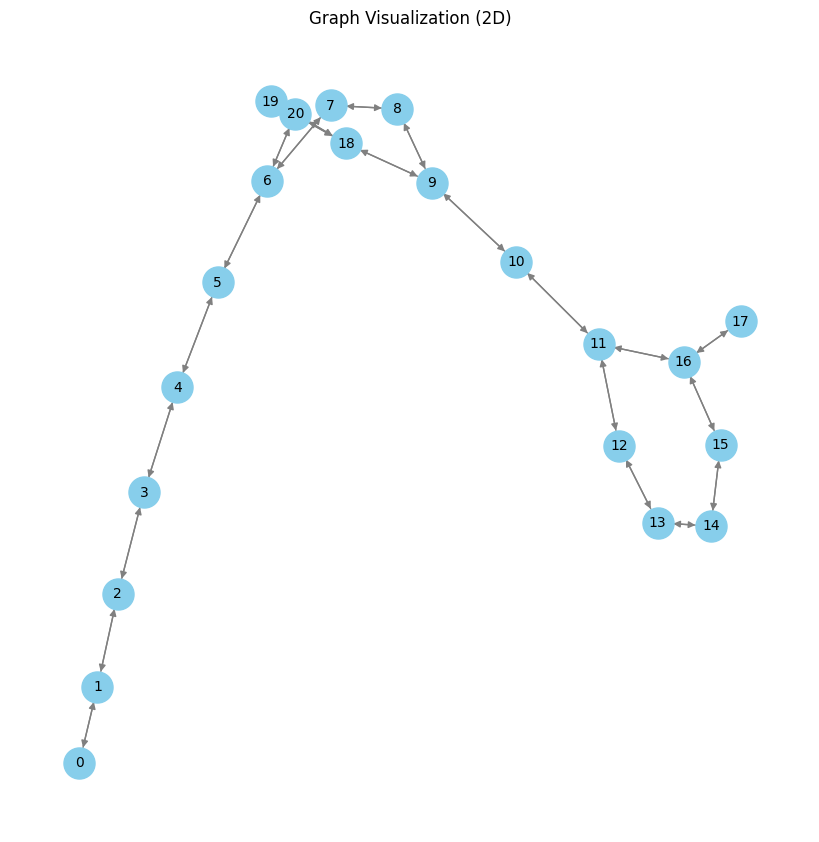

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import py3Dmol
from rdkit.Chem import rdMolTransforms

def visualize_graph_2d(graph):
    nx_g = dgl.to_networkx(graph, node_attrs=['feat'], edge_attrs=['feat'])
    pos = nx.spring_layout(nx_g)
    labels = {i: f'{i}' for i in range(graph.number_of_nodes())}

    plt.figure(figsize=(8, 8))
    nx.draw(nx_g, pos, with_labels=True, labels=labels, node_color='skyblue', edge_color='gray', node_size=500, font_size=10)
    plt.title("Graph Visualization (2D)")
    plt.show()



def visualize_graph_3d(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)
    mb = Chem.MolToMolBlock(mol)

    viewer = py3Dmol.view(width=800, height=600)
    viewer.addModel(mb, 'sdf')
    viewer.setStyle({'stick': {}})
    viewer.zoomTo()
    viewer.show()

example_graph = train_df.iloc[81]['graph']
visualize_graph_2d(example_graph)
example_smiles = train_df.iloc[81]['Smiles']
visualize_graph_3d(example_smiles)

In [ ]:
df = train_df.reset_index()
df_sorted = df.sort_values(by='pChEMBL Value', ascending=False)
df_sorted

,index,Smiles,pChEMBL Value,Molecular Weight,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,graph
232,408,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,9.12,770.54,41.209278,30.803580,2,0,65.673495,2.514691,...,108.263758,770.146236,9.168408,13038,90,286.0,343.0,19.125000,11.000000,"Graph(num_nodes=52, num_edges=114,\n ndat..."
81,216,CCCCCCc1ccc(Oc2ccccc2Br)c(O)c1,9.12,349.27,15.694249,12.506281,0,0,26.820303,2.341875,...,54.069262,348.072492,8.287440,1094,28,100.0,112.0,6.805556,4.888889,"Graph(num_nodes=21, num_edges=44,\n ndata..."
41,41,NC(=O)c1c[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O...,9.12,769.53,41.209278,30.803580,2,1,65.673495,2.514691,...,108.263758,769.137862,9.266721,13038,90,286.0,343.0,19.125000,11.000000,"Graph(num_nodes=52, num_edges=114,\n ndat..."
222,290,CCCCCCc1ccc(Oc2ccccc2C)c(O)c1,9.12,284.40,15.694249,12.506281,0,0,26.820303,2.341875,...,54.069262,284.177630,6.315058,1094,28,100.0,112.0,6.805556,4.888889,"Graph(num_nodes=21, num_edges=44,\n ndata..."
104,72,CCCCCCc1ccc(Oc2ccccc2CN2CCN(C)CC2)c(O)c1,9.00,382.55,21.351103,15.775797,0,2,36.438577,2.365205,...,62.728220,382.262028,6.165517,2396,39,138.0,156.0,8.277778,6.388889,"Graph(num_nodes=28, num_edges=60,\n ndata..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,32,Fc1ccccc1-c1cc(CNCc2ccccc2)c2cnc3cc(Br)ccc3n12,4.27,460.35,23.977329,17.481162,0,1,40.098195,2.557311,...,80.380089,459.074638,9.368870,2452,50,164.0,197.0,7.611111,6.527778,"Graph(num_nodes=30, num_edges=68,\n ndata..."
146,415,O=C(CN1C(=O)/C(=C\c2ccc(F)cc2)SC1=S)c1ccccc1,4.26,357.43,18.660575,15.137579,0,0,31.227378,2.429149,...,72.586605,357.029349,9.917482,1456,35,124.0,144.0,7.888889,5.277778,"Graph(num_nodes=24, num_edges=52,\n ndata..."
167,208,O=C(Nc1cc(Cl)ccc1Cl)C1CC(=O)N(C2CCCCC2)C1,4.25,355.26,17.953468,14.756650,0,0,29.687812,2.420531,...,71.207395,354.090183,8.234655,1259,34,120.0,140.0,7.638889,5.027778,"Graph(num_nodes=23, num_edges=50,\n ndata..."
179,21,C/C=C(\C)c1cc(O)c(C)c(OC(=O)c2c(/C(C)=C/C)cc(O...,4.25,382.46,21.017254,18.609542,0,0,34.562352,2.463488,...,63.395452,382.178024,7.077371,1977,50,142.0,169.0,12.833333,6.333333,"Graph(num_nodes=28, num_edges=58,\n ndata..."


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl.nn import GATConv, GINConv, SAGEConv, TAGConv
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from dgl.dataloading import GraphDataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

in_feats = len(get_atom_features(Chem.MolFromSmiles('C').GetAtomWithIdx(0)))
h_feats = 1024
num_classes = 1
learning_rate = 0.001
batch_size = 128
num_epochs = 2000
dropout_rate = 0.23


# Model defintions
class GIN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes, dropout_rate):
        super(GIN, self).__init__()
        #First GINConv Block
        self.mlp1 = nn.Sequential(
            nn.Linear(in_feats, h_feats),
            nn.BatchNorm1d(h_feats),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(h_feats, h_feats),
            nn.BatchNorm1d(h_feats),
        )
        self.conv1 = GINConv(self.mlp1, 'sum', learn_eps=True)
        self.bn1 = nn.BatchNorm1d(h_feats)

        #Second GINConv Block
        self.mlp2 = nn.Sequential(
            nn.Linear(h_feats, h_feats),
            nn.BatchNorm1d(h_feats),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(h_feats, h_feats),
            nn.BatchNorm1d(h_feats),
        )
        self.conv2 = GINConv(self.mlp2, 'sum', learn_eps=True)
        self.bn2 = nn.BatchNorm1d(h_feats)

        self.mlp3 = nn.Sequential(
            nn.Linear(h_feats, h_feats),
            nn.BatchNorm1d(h_feats),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(h_feats, h_feats),
            nn.BatchNorm1d(h_feats),
        )
        self.conv3 = GINConv(self.mlp3, 'sum', learn_eps=True)
        self.bn3 = nn.BatchNorm1d(h_feats)

        self.mlp4 = nn.Sequential(
            nn.Linear(h_feats, h_feats),
            nn.BatchNorm1d(h_feats),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(h_feats, h_feats),
            nn.BatchNorm1d(h_feats),
        )
        self.conv4 = GINConv(self.mlp4, 'sum', learn_eps=True)
        self.bn4 = nn.BatchNorm1d(h_feats)

        #Concatenated Pooling and Linear Layers
        self.linear1 = nn.Linear(h_feats * 3, h_feats)
        self.bn_lin1 = nn.BatchNorm1d(h_feats)
        self.linear2 = nn.Linear(h_feats, h_feats // 2)
        self.bn_lin2 = nn.BatchNorm1d(h_feats // 2)
        self.linear3 = nn.Linear(h_feats // 2, num_classes)  # Output layer
        self.dropout = nn.Dropout(dropout_rate)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, GINConv):
                if isinstance(m.apply_func, nn.Linear):
                    nn.init.xavier_uniform_(m.apply_func.weight)
                    nn.init.constant_(m.apply_func.bias, 0)
                elif isinstance(m.apply_func, nn.Sequential):
                    for layer in m.apply_func:
                        if isinstance(layer, nn.Linear):
                            nn.init.xavier_uniform_(layer.weight)
                            nn.init.constant_(layer.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, g, in_feat):
        # Layer 1
        h = self.conv1(g, in_feat)
        h = self.bn1(h)
        h = F.relu(h)  # Standard ReLU
        h_res1 = h # Residual
        h = self.dropout(h)


        # Layer 2 with Residual
        h = self.conv2(g, h)
        h = self.bn2(h)
        h = F.relu(h)
        h = h + h_res1  
        h_res2 = h # Store for next residual
        h = self.dropout(h)

        #Layer 3 with Residual
        h = self.conv3(g, h)
        h = self.bn3(h)
        h = F.relu(h)
        h = h + h_res2
        h_res3 = h
        h = self.dropout(h)

        #Layer 4 w Residual
        h = self.conv4(g,h)
        h = self.bn4(h)
        h = F.relu(h)
        h = h + h_res3
        h = self.dropout(h)

        #Global Pooling (Concatenate Mean, Max, and Sum)
        g.ndata['h'] = h
        hg_mean = dgl.mean_nodes(g, 'h')
        hg_max = dgl.max_nodes(g, 'h')
        hg_sum = dgl.sum_nodes(g, 'h')
        hg = torch.cat([hg_mean, hg_max, hg_sum], dim=1)  

        #Linear Layers MLP
        h = self.linear1(hg)
        h = self.bn_lin1(h)
        h = F.relu(h)  
        h = self.dropout(h)
        h = self.linear2(h)
        h = self.bn_lin2(h)
        h = F.relu(h)
        h = self.dropout(h)
        h = self.linear3(h)  # Output layer

        return h.squeeze()


# Data Loaders and Label Scaling 
scaler = StandardScaler()
train_labels_scaled = scaler.fit_transform(train_df['pChEMBL Value'].values.reshape(-1, 1)).flatten()
valid_labels_scaled = scaler.transform(valid_df['pChEMBL Value'].values.reshape(-1, 1)).flatten()
test_labels_scaled = scaler.transform(test_df['pChEMBL Value'].values.reshape(-1, 1)).flatten()

train_loader = GraphDataLoader(list(zip(train_df['graph'], train_labels_scaled)), batch_size=batch_size, shuffle=True, collate_fn=collate, drop_last=False, num_workers=2)
valid_loader = GraphDataLoader(list(zip(valid_df['graph'], valid_labels_scaled)), batch_size=batch_size, shuffle=False, collate_fn=collate, drop_last=False, num_workers=2)
test_loader = GraphDataLoader(list(zip(test_df['graph'], test_labels_scaled)), batch_size=batch_size, shuffle=False, collate_fn=collate, drop_last=False, num_workers=2)

# Model Initialization, Optimizer, and Loss

model = GIN(in_feats, h_feats, num_classes, dropout_rate).to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# OneCycleLR scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, epochs=num_epochs,
                                                steps_per_epoch=len(train_loader), pct_start=0.1)
loss_fn = nn.MSELoss()
# store metrics
train_losses = []
valid_mses = []
valid_rmses = []  
valid_r2s = []
best_val_loss = float('inf') # instantiate at inf reduce as better val losses reached
best_model_state = None
patience = 250
early_stopping_counter = 0

# Train Loop
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    total_loss = 0

    for batch_idx, (batched_graph, labels) in enumerate(train_loader):
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model(batched_graph, batched_graph.ndata['feat'])
        loss = loss_fn(predictions, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()  # Step every batch
        total_loss += loss.item()

        if len(train_loader) > 0:
            if (batch_idx + 1) % max(1, len(train_loader) // 5) == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

    avg_loss = total_loss / len(train_loader) if len(train_loader) > 0 else 0
    train_losses.append(avg_loss)

    model.eval()
    with torch.no_grad():
        val_predictions = []
        val_labels = []
        for batched_graph, labels in valid_loader:
            batched_graph = batched_graph.to(device)
            labels = labels.to(device)
            predictions = model(batched_graph, batched_graph.ndata['feat'])
            val_predictions.extend(predictions.cpu().tolist())
            val_labels.extend(labels.cpu().tolist())

        val_predictions = scaler.inverse_transform(np.array(val_predictions).reshape(-1, 1)).flatten()
        val_labels = scaler.inverse_transform(np.array(val_labels).reshape(-1, 1)).flatten()

        val_mse = mean_squared_error(val_labels, val_predictions)
        val_rmse = np.sqrt(val_mse)  # Calculate RMSE
        val_r2 = r2_score(val_labels, val_predictions)
        valid_mses.append(val_mse)
        valid_rmses.append(val_rmse)  # Store RMSE
        valid_r2s.append(val_r2)

    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Val MSE: {val_mse:.4f}, Val RMSE: {val_rmse:.4f}, Val R-squared: {val_r2:.4f}, Time: {epoch_duration:.2f}s")

    # Early Stopping Check 
    if val_rmse < best_val_loss:
        best_val_loss = val_rmse
        best_model_state = model.state_dict()
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

if best_model_state:
    model.load_state_dict(best_model_state)

model.eval()
test_predictions = []
test_labels = []
with torch.no_grad():
    for batched_graph, labels in test_loader:
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        predictions = model(batched_graph, batched_graph.ndata['feat'])
        test_predictions.extend(predictions.cpu().tolist())
        test_labels.extend(labels.cpu().tolist())

test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
test_labels = scaler.inverse_transform(np.array(test_labels).reshape(-1, 1)).flatten()

test_mse = mean_squared_error(test_labels, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(test_labels, test_predictions)
print(f"Test MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, R-squared: {test_r2:.4f}")

# Visualizations
plt.figure(figsize=(12, 6))
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Training Loss')
sns.lineplot(x=range(1, len(valid_mses) + 1), y=valid_mses, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss/MSE')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(x=range(1, len(valid_rmses) + 1), y=valid_rmses, label='Validation RMSE')  # Plot RMSE
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(x=range(1, len(valid_r2s) + 1), y=valid_r2s, label='Validation R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.title('Validation R-squared')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel('Actual pChEMBL Value')
plt.ylabel('Predicted pChEMBL Value')
plt.title('Actual vs. Predicted pChEMBL Values (Test Set)')
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], color='red', linestyle='--')
plt.grid(True)
plt.show()

residuals = test_labels - test_predictions
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals (Test Set)')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(test_predictions, residuals, alpha=0.5)
plt.title('Residuals vs. Predicted Values (Test Set)')
plt.xlabel('Predicted pChEMBL Value')
plt.ylabel('Residual')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

In [ ]:
!pip install chemfunc

# inference on small drugs dataset

In [ ]:
from pathlib import Path
from chemfunc.sdf_to_smiles import sdf_to_smiles

sdf_to_smiles(
    data_path=Path('e-Drug3D_2118.sdf'),
    save_path=Path('molecules.csv')
)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl.nn import GINConv
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
from sklearn.preprocessing import StandardScaler

# inference


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class GIN(nn.Module):  
    def __init__(self, in_feats, h_feats, num_classes, dropout_rate):
        super(GIN, self).__init__()
        self.mlp1 = nn.Sequential(
            nn.Linear(in_feats, h_feats),
            nn.BatchNorm1d(h_feats),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(h_feats, h_feats),
            nn.BatchNorm1d(h_feats),
        )
        self.conv1 = GINConv(self.mlp1, 'sum', learn_eps=True)

        self.bn1 = nn.BatchNorm1d(h_feats)
        self.mlp2 = nn.Sequential(
            nn.Linear(h_feats, h_feats),
            nn.BatchNorm1d(h_feats),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(h_feats, h_feats),
            nn.BatchNorm1d(h_feats),
        )
        self.conv2 = GINConv(self.mlp2, 'sum', learn_eps=True)
        self.bn2 = nn.BatchNorm1d(h_feats)


        self.mlp3 = nn.Sequential(
            nn.Linear(h_feats, h_feats),
            nn.BatchNorm1d(h_feats),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(h_feats, h_feats),
            nn.BatchNorm1d(h_feats),
        )
        self.conv3 = GINConv(self.mlp3, 'sum', learn_eps=True)
        self.bn3 = nn.BatchNorm1d(h_feats)

        self.mlp4 = nn.Sequential(
            nn.Linear(h_feats, h_feats),
            nn.BatchNorm1d(h_feats),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(h_feats, h_feats),
            nn.BatchNorm1d(h_feats),
        )
        self.conv4 = GINConv(self.mlp4, 'sum', learn_eps=True)
        self.bn4 = nn.BatchNorm1d(h_feats)


        self.linear1 = nn.Linear(h_feats * 3, h_feats)
        self.bn_lin1 = nn.BatchNorm1d(h_feats)
        self.linear2 = nn.Linear(h_feats, h_feats // 2)
        self.bn_lin2 = nn.BatchNorm1d(h_feats // 2)
        self.linear3 = nn.Linear(h_feats // 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, GINConv):
                if isinstance(m.apply_func, nn.Linear):
                    nn.init.xavier_uniform_(m.apply_func.weight)
                    nn.init.constant_(m.apply_func.bias, 0)
                elif isinstance(m.apply_func, nn.Sequential):
                    for layer in m.apply_func:
                        if isinstance(layer, nn.Linear):
                            nn.init.xavier_uniform_(layer.weight)
                            nn.init.constant_(layer.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = self.bn1(h)
        h = F.relu(h)
        h_res1 = h
        h = self.dropout(h)

        h = self.conv2(g, h)
        h = self.bn2(h)
        h = F.relu(h)
        h = h + h_res1
        h_res2 = h
        h = self.dropout(h)

        h = self.conv3(g, h)
        h = self.bn3(h)
        h = F.relu(h)
        h = h + h_res2
        h_res3 = h
        h = self.dropout(h)

        h = self.conv4(g, h)
        h = self.bn4(h)
        h = F.relu(h)
        h = h + h_res3
        h = self.dropout(h)

        g.ndata['h'] = h
        hg_mean = dgl.mean_nodes(g, 'h')
        hg_max = dgl.max_nodes(g, 'h')
        hg_sum = dgl.sum_nodes(g, 'h')
        hg = torch.cat([hg_mean, hg_max, hg_sum], dim=1)  # Concatenate

        h = self.linear1(hg)
        h = self.bn_lin1(h)
        h = F.relu(h)
        h = self.dropout(h)
        h = self.linear2(h)
        h = self.bn_lin2(h)
        h = F.relu(h)
        h = self.dropout(h)
        h = self.linear3(h)
        return h.squeeze()

# Feature Extraction Functions for each mol 

def get_atom_features(atom):
    atom_type = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'I', 'Unknown']
    atom_type_enc = [0.0] * len(atom_type)
    try:
        atom_type_enc[atom_type.index(atom.GetSymbol()) if atom.GetSymbol() in atom_type else -1] = 1.0
    except ValueError:
        atom_type_enc[-1] = 1.0

    hybridization_types = [
        Chem.rdchem.HybridizationType.SP,
        Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3,
        Chem.rdchem.HybridizationType.SP3D,
        Chem.rdchem.HybridizationType.SP3D2,
        Chem.rdchem.HybridizationType.UNSPECIFIED,
        Chem.rdchem.HybridizationType.S,
    ]
    hybridization = [0.0] * len(hybridization_types)
    try:
        hybridization_idx = hybridization_types.index(atom.GetHybridization())
        hybridization[hybridization_idx] = 1.0
    except ValueError:
        hybridization[-1] = 1.0

    atomic_num = [float(atom.GetAtomicNum())]
    degree = [float(atom.GetDegree())]
    total_num_hs = [float(atom.GetTotalNumHs())]
    formal_charge = [float(atom.GetFormalCharge())]
    is_aromatic = [float(atom.GetIsAromatic())]
    num_radical_electrons = [float(atom.GetNumRadicalElectrons())]
    in_ring = [float(atom.IsInRing())]

    features = atomic_num + degree + total_num_hs + is_aromatic + formal_charge + atom_type_enc + hybridization + num_radical_electrons + in_ring
    return torch.tensor(features, dtype=torch.float)


def get_bond_features(bond):
    bond_type = [
        Chem.rdchem.BondType.SINGLE,
        Chem.rdchem.BondType.DOUBLE,
        Chem.rdchem.BondType.TRIPLE,
        Chem.rdchem.BondType.AROMATIC,
    ]
    bond_feats = [int(bond.GetBondType() == bt) for bt in bond_type]
    bond_feats.extend([
        int(bond.GetIsConjugated()),
        int(bond.IsInRing()),
        int(bond.GetStereo() > 0),
    ])

    stereo_types = [
        Chem.rdchem.BondStereo.STEREONONE,
        Chem.rdchem.BondStereo.STEREOANY,
        Chem.rdchem.BondStereo.STEREOZ,
        Chem.rdchem.BondStereo.STEREOE,
        Chem.rdchem.BondStereo.STEREOCIS,
        Chem.rdchem.BondStereo.STEREOTRANS
    ]
    stereo_feats = [int(bond.GetStereo() == st) for st in stereo_types]
    bond_feats.extend(stereo_feats)
    return torch.tensor(bond_feats, dtype=torch.float)


def smiles_to_graph(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        fragments = Chem.GetMolFrags(mol, asMols=True)
        if len(fragments) > 1:
            mol = max(fragments, key=lambda m: m.GetNumAtoms())

        g = dgl.DGLGraph()
        g.add_nodes(mol.GetNumAtoms())

        node_features = [get_atom_features(atom) for atom in mol.GetAtoms()]
        g.ndata['feat'] = torch.stack(node_features)

        src_list = []
        dst_list = []
        edge_features = []
        for bond in mol.GetBonds():
            u = bond.GetBeginAtomIdx()
            v = bond.GetEndAtomIdx()
            src_list.extend([u, v])
            dst_list.extend([v, u])
            bond_feat = get_bond_features(bond).tolist()
            edge_features.extend([bond_feat, bond_feat])

        g.add_edges(src_list, dst_list)

        if edge_features:
            g.edata['feat'] = torch.tensor(edge_features, dtype=torch.float)
        else:
            num_bond_features = 10
            g.edata['feat'] = torch.zeros((0, num_bond_features), dtype=torch.float)
        return g

    except Exception as e:
        print(f"Error converting SMILES {smiles}: {str(e)}")
        return None


in_feats = len(get_atom_features(Chem.MolFromSmiles('C').GetAtomWithIdx(0)))
h_feats = 1024
dropout_rate = 0.2
model = GIN(in_feats, h_feats, num_classes=1, dropout_rate=dropout_rate)

model.load_state_dict(torch.load("model_weights.pth"))  
model = model.to(device) 
model.eval() 

scaler = StandardScaler()
scaler.fit_transform(train_df['pChEMBL Value'].values.reshape(-1, 1)).flatten()


def predict_pchembl(smiles_string, model, scaler):
    graph = smiles_to_graph(smiles_string)
    if graph is None:
        return None 
    graph = graph.to(device)
    features = graph.ndata['feat']

    with torch.no_grad():  
        prediction_scaled = model(graph, features)
        
    prediction_unscaled = scaler.inverse_transform(prediction_scaled.cpu().numpy().reshape(-1, 1))[0, 0]

    return prediction_unscaled


def predict_on_sdf(sdf_path, model, scaler, output_csv="predictions.csv"):

    try:
        suppl = Chem.ForwardSDMolSupplier(sdf_path, sanitize=True, removeHs=False)
        data = []
        for mol in suppl:
            if mol is None:
                continue  

            smiles = Chem.MolToSmiles(mol)
            if smiles is None:
                continue 
            prediction = predict_pchembl(smiles, model, scaler)

            properties = {}
            for prop_name in mol.GetPropNames():
                try:
                    properties[prop_name] = mol.GetProp(prop_name)
                except KeyError:
                    properties[prop_name] = None 

            data.append({
                'SMILES': smiles,
                'Predicted_pChEMBL': prediction if prediction is not None else np.nan,  
                **properties 
            })


        df = pd.DataFrame(data)
        df.to_csv(output_csv, index=False)
        print(f"Predictions saved to {output_csv}")


    except Exception as e:
        print(f"Error processing SDF file: {e}")

sdf_file_path = "e-Drug3D_2118.sdf"
predict_on_sdf(sdf_file_path, model, scaler)

Using device: cuda


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(
[06:36:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
/usr/local/lib/python3.11/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(
[06:36:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
/usr/local/lib/python3.11/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(
[06:36:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
/usr/local/lib/python3.11/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by

Predictions saved to predictions.csv


[06:36:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
/usr/local/lib/python3.11/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(
[06:36:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
/usr/local/lib/python3.11/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(
[06:36:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
/usr/local/lib/python3.11/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(
[06:36:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
/usr/local/lib/python3.11/dist-packages/dg

In [ ]:
import pandas as pd
dfPred = pd.read_csv('predictions.csv')
dfPred

,SMILES,Predicted_pChEMBL,status,cas,name,ID
0,[H]c1nc(N([H])S(=O)(=O)c2c([H])c([H])c(N([H])[...,4.736452,DISCONTINUED,144-83-2,SULFAPYRIDINE,1
1,[H]Oc1c([H])c([H])c(C([H])([H])[C@@]([H])(C(=O...,8.327208,-,57773-63-4,TRIPTORELIN,2
2,[H]c1nc([H])n([H])c1C([H])([H])C([H])([H])N([H...,5.725726,DISCONTINUED,51-45-6,HISTAMINE,3
3,[H]N1C(=O)N([H])C(=O)C(C([H])([H])C([H])([H])[...,4.842614,DISCONTINUED,125-40-6,BUTABARBITAL,4
4,[H]C1=C2C([H])([H])C([H])([H])[C@@]3([H])[C@]4...,4.934049,DISCONTINUED,56-47-3,DESOXYCORTICOSTERONE ACETATE,5
...,...,...,...,...,...,...
2090,[H]c1nc2c(c([H])c1[H])C([H])([H])C([H])([H])C(...,7.896020,-,558447-26-0,MAVORIXAFOR,2114
2091,[H]/C(C(=O)c1c([H])c([H])c(SC([H])([H])[H])c([...,4.848541,-,923978-27-2,ELAFIBRANOR,2115
2092,[H]c1c(OC([H])([H])[H])c(OC([H])([H])[H])c([H]...,4.581525,DISCONTINUED,63-12-7,BENZQUINAMIDE,2116
2093,[H]Oc1c([H])c([H])c([C@@]([H])(O[H])[C@]([H])(...,5.227258,DISCONTINUED,530-08-5,ISOETHARINE,2117


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors 

def analyze_predictions(predictions_csv, top_n=10):
    df = pd.read_csv(predictions_csv)

    if 'Predicted_pChEMBL' not in df.columns or 'SMILES' not in df.columns:
        print("Error: 'Predicted_pChEMBL' or 'SMILES' column missing.")
        return

    df.dropna(subset=['Predicted_pChEMBL', 'SMILES'], inplace=True)
    if df.empty:
        print("Error: No valid predictions after removing missing values.")
        return

    top_compounds = df.sort_values(by='Predicted_pChEMBL', ascending=False).head(top_n)
    print(f"\nTop {top_n} Most Bioactive Compounds (Highest Predicted pChEMBL):\n")
    print(top_compounds[['SMILES', 'Predicted_pChEMBL']])

    print("\nDescriptive Statistics of Predicted pChEMBL Values:\n")
    print(df['Predicted_pChEMBL'].describe())

    plt.figure(figsize=(10, 6))
    sns.histplot(df['Predicted_pChEMBL'], kde=True, bins=30)
    plt.title('Distribution of Predicted pChEMBL Values')
    plt.xlabel('Predicted pChEMBL Value')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df['Predicted_pChEMBL'])
    plt.title('Boxplot of Predicted pChEMBL Values')
    plt.xlabel('Predicted pChEMBL Value')
    plt.show()


    def calculate_properties(smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None  

        return {
            'MolWt': Descriptors.MolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'TPSA': Descriptors.TPSA(mol),
            'NumHDonors': Descriptors.NumHDonors(mol),
            'NumHAcceptors': Descriptors.NumHAcceptors(mol),
            'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
        }

    properties = df['SMILES'].apply(calculate_properties)
    properties_df = pd.DataFrame(properties.tolist())  
    df = pd.concat([df, properties_df], axis=1)

    df.dropna(subset=['MolWt', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds'], inplace=True)

    print("\nCorrelation with Molecular Properties:\n")
    correlation_matrix = df[['Predicted_pChEMBL', 'MolWt', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds']].corr()
    print(correlation_matrix['Predicted_pChEMBL'].sort_values(ascending=False))

    properties_to_plot = ['MolWt', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds']
    for prop in properties_to_plot:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=df[prop], y=df['Predicted_pChEMBL'], alpha=0.5)
        plt.title(f'Predicted pChEMBL vs. {prop}')
        plt.xlabel(prop)
        plt.ylabel('Predicted pChEMBL Value')
        plt.grid(True)
        plt.show()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Heatmap of Predicted pChEMBL and Molecular Properties')
    plt.show()



predictions_file = "predictions.csv"  
analyze_predictions(predictions_file, top_n=5)

# Results

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole   
from rdkit.Chem import Descriptors

def analyze_predictions(predictions_csv, top_n=20):  
    df = pd.read_csv(predictions_csv)

    if 'Predicted_pChEMBL' not in df.columns or 'SMILES' not in df.columns:
        print("Error: 'Predicted_pChEMBL' or 'SMILES' column missing.")
        return

    df.dropna(subset=['Predicted_pChEMBL', 'SMILES'], inplace=True)
    if df.empty:
        print("Error: No valid predictions after removing missing values.")
        return
    top_compounds = df.sort_values(by='Predicted_pChEMBL', ascending=False).head(top_n)
    print(f"\nTop {top_n} Most Bioactive Compounds (Highest Predicted pChEMBL):\n")

    mols = [Chem.MolFromSmiles(smiles) for smiles in top_compounds['SMILES']]
    for mol, pchembl in zip(mols, top_compounds['Predicted_pChEMBL']):
        if mol is not None:  
             mol.SetProp("pChEMBL", f"{pchembl:.2f}")

    img = Draw.MolsToGridImage(
        [m for m in mols if m is not None], 
        molsPerRow=4,
        subImgSize=(300, 200),
        legends=[mol.GetProp("pChEMBL") if mol is not None else "" for mol in mols],  # Handle None
        useSVG=True 
    )
    display(img)  

    print("\nDescriptive Statistics of Predicted pChEMBL Values:\n")
    print(df['Predicted_pChEMBL'].describe())

    plt.figure(figsize=(10, 6))
    sns.histplot(df['Predicted_pChEMBL'], kde=True, bins=30)
    plt.title('Distribution of Predicted pChEMBL Values')
    plt.xlabel('Predicted pChEMBL Value')
    plt.ylabel('Frequency')
    plt.show()


    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df['Predicted_pChEMBL'])
    plt.title('Boxplot of Predicted pChEMBL Values')
    plt.xlabel('Predicted pChEMBL Value')
    plt.show()

    def calculate_properties(smiles):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return None  

            return {
                'MolWt': Descriptors.MolWt(mol),
                'LogP': Descriptors.MolLogP(mol),
                'TPSA': Descriptors.TPSA(mol),
                'NumHDonors': Descriptors.NumHDonors(mol),
                'NumHAcceptors': Descriptors.NumHAcceptors(mol),
                'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
            }
        except Exception as e:
            print(f"Error calculating properties for SMILES {smiles}: {e}")
            return None

    properties = df['SMILES'].apply(calculate_properties)
    properties_df = pd.DataFrame(properties.tolist())  
    df = pd.concat([df, properties_df], axis=1)

    df.dropna(subset=['MolWt', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds'], inplace=True)

    # corr heatmap
    print("\nCorrelation with Molecular Properties:\n")
    correlation_matrix = df[['Predicted_pChEMBL', 'MolWt', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds']].corr()
    print(correlation_matrix['Predicted_pChEMBL'].sort_values(ascending=False))

    properties_to_plot = ['MolWt', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds']
    for prop in properties_to_plot:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=df[prop], y=df['Predicted_pChEMBL'], alpha=0.5)
        plt.title(f'Predicted pChEMBL vs. {prop}')
        plt.xlabel(prop)
        plt.ylabel('Predicted pChEMBL Value')
        plt.grid(True)
        plt.show()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Heatmap of Predicted pChEMBL and Molecular Properties')
    plt.show()



predictions_file = "predictions.csv"  
analyze_predictions(predictions_file, top_n=20)  

In [ ]:
dfPred

,SMILES,Predicted_pChEMBL,status,cas,name,ID
0,[H]c1nc(N([H])S(=O)(=O)c2c([H])c([H])c(N([H])[...,4.736452,DISCONTINUED,144-83-2,SULFAPYRIDINE,1
1,[H]Oc1c([H])c([H])c(C([H])([H])[C@@]([H])(C(=O...,8.327208,-,57773-63-4,TRIPTORELIN,2
2,[H]c1nc([H])n([H])c1C([H])([H])C([H])([H])N([H...,5.725726,DISCONTINUED,51-45-6,HISTAMINE,3
3,[H]N1C(=O)N([H])C(=O)C(C([H])([H])C([H])([H])[...,4.842614,DISCONTINUED,125-40-6,BUTABARBITAL,4
4,[H]C1=C2C([H])([H])C([H])([H])[C@@]3([H])[C@]4...,4.934049,DISCONTINUED,56-47-3,DESOXYCORTICOSTERONE ACETATE,5
...,...,...,...,...,...,...
2090,[H]c1nc2c(c([H])c1[H])C([H])([H])C([H])([H])C(...,7.896020,-,558447-26-0,MAVORIXAFOR,2114
2091,[H]/C(C(=O)c1c([H])c([H])c(SC([H])([H])[H])c([...,4.848541,-,923978-27-2,ELAFIBRANOR,2115
2092,[H]c1c(OC([H])([H])[H])c(OC([H])([H])[H])c([H]...,4.581525,DISCONTINUED,63-12-7,BENZQUINAMIDE,2116
2093,[H]Oc1c([H])c([H])c([C@@]([H])(O[H])[C@]([H])(...,5.227258,DISCONTINUED,530-08-5,ISOETHARINE,2117


In [ ]:
import pandas as pd

df_sorted = dfPred.sort_values(by='Predicted_pChEMBL', ascending=False)

df_sorted.head(20)

,SMILES,Predicted_pChEMBL,status,cas,name,ID
1456,[H]Oc1c([H])c([H])c2c([H])c1-c1c(O[H])c(C([H])...,11.299360,-,372151-71-8,TELAVANCIN,1480
1687,[H]Oc1c([H])c(O[C@@]2([H])O[C@]([H])(C([H])([H...,9.845619,-,171500-79-1,DALBAVANCIN,1711
1289,[H]OC([H])([H])[C@]1([H])O[C@@]([H])(O[C@@]([H...,9.827287,-,11056-06-7,BLEOMYCIN,1313
1768,[H]O[C@]1([H])[C@@]([H])(O[H])[C@@]2([H])O[C@@...,9.274026,-,343306-71-8,SUGAMMADEX,1792
1830,[H]O[C@@]1([H])[C@]([H])(Oc2c(I)c(C([H])([H])[...,9.097518,-,108212-76-6,CALICHEAMICIN,1854
897,[H]OC([H])([H])[C@]1([H])C(=O)N([H])[C@@]([H])...,9.029176,-,103060-53-3,DAPTOMYCIN,918
1380,[H]C([H])([H])C([H])([H])C([H])([H])C([H])([H]...,8.992028,DISCONTINUED,63-89-8,COLFOSCERIL PALMITATE,1404
891,[H]Oc1c([H])c([H])c([C@]([H])(O[H])[C@@]([H])(...,8.942022,-,235114-32-6,MICAFUNGIN,912
713,[H]Oc1c([H])c([H])c(C([H])([H])C([H])([H])C([H...,8.933165,DISCONTINUED,128470-16-6,ARBUTAMINE,730
1608,[H]OC([H])([H])C([H])([H])OC([H])([H])C([H])([...,8.909350,-,9002-92-0,POLIDOCANOL,1632


In [ ]:
top_20 = df_sorted.head(20)


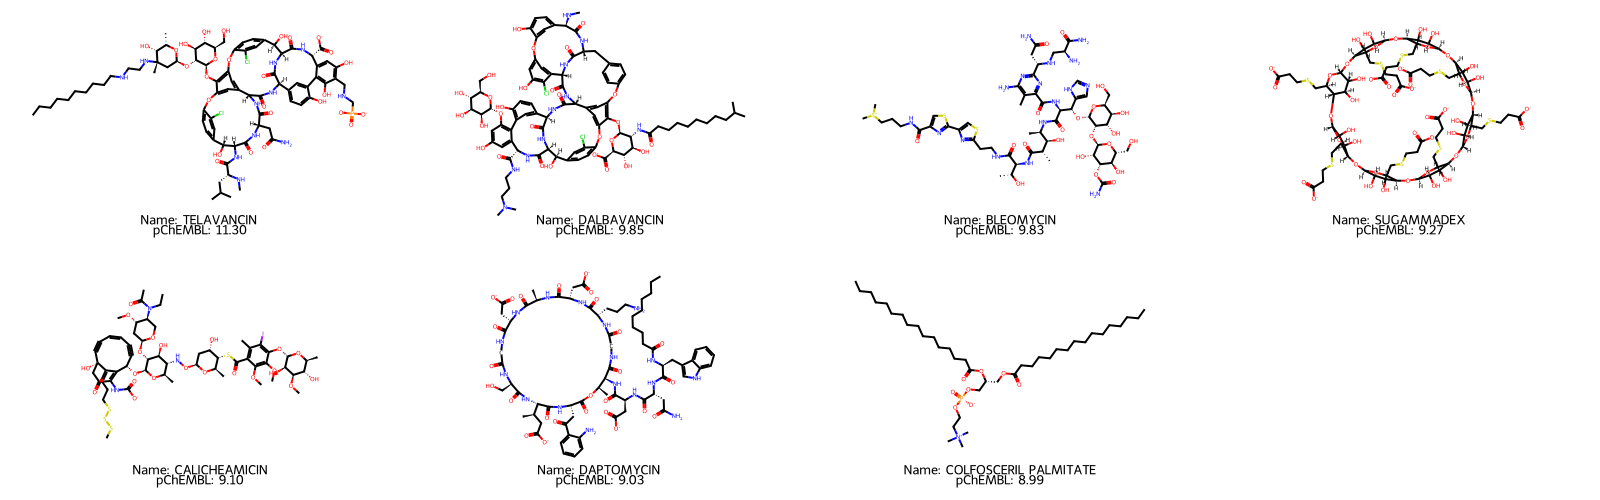

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

def display_top_molecules_with_info(predictions_csv, top_n=20):
    df = pd.read_csv(predictions_csv)

    required_columns = ['SMILES', 'Predicted_pChEMBL', 'cas', 'name']
    if not all(col in df.columns for col in required_columns):
        print(f"Error: Missing required columns.  Must have: {required_columns}")
        return

    df.dropna(subset=['SMILES', 'Predicted_pChEMBL'], inplace=True)
    if df.empty:
        print("Error: No valid data after dropping NaN values.")
        return

    top_compounds = df.sort_values(by='Predicted_pChEMBL', ascending=False).head(top_n)

    mols = []
    legends = []
    for idx, row in top_compounds.iterrows():
        smiles = row['SMILES']
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"Invalid SMILES: {smiles}, skipping.")
            continue  

        cas = row['cas'] if pd.notna(row['cas']) else 'N/A'
        name = row['name'] if pd.notna(row['name']) else 'N/A'
        pchembl = f"{row['Predicted_pChEMBL']:.2f}"

        legend = f"Name: {name}\npChEMBL: {pchembl}"
        legends.append(legend)
        mols.append(mol)

    if not mols: 
        print("No valid molecules to display.")
        return

    img = Draw.MolsToGridImage(
        mols,
        molsPerRow=4,
        subImgSize=(400, 250),  
        legends=legends,
        useSVG=True
    )
    display(img)  

predictions_file = "predictions.csv"  
display_top_molecules_with_info(predictions_file, top_n=7)